In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import re
import contractions
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix,ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments, Trainer


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Added to fix LookupError

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
df = pd.read_csv('reply_classification_dataset.csv')
df.head()

,reply,label
0,Can we discuss pricing??,NEUTRAL
1,"Im excited to explore this further, plz send c...",POSITIVE
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


In [6]:
df['label'].unique()

array(['NEUTRAL', 'POSITIVE', 'negative', 'neutral', 'positive',
       'NEGATIVE', 'Positive', 'Neutral', 'Negative'], dtype=object)

In [7]:
def func(label):
    if label in ['NEUTRAL', 'neutral', 'Neutral']:
        return 'neutral'
    elif label in ['POSITIVE', 'positive', 'Positive']:
        return 'positive'
    else:
        return 'negative'

In [8]:
df['label'] = df['label'].apply(func)
print(df['label'].unique())

['neutral' 'positive' 'negative']


In [9]:
df.head()

,reply,label
0,Can we discuss pricing??,neutral
1,"Im excited to explore this further, plz send c...",positive
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


In [10]:
df.isna().sum()

,0
reply,0
label,0


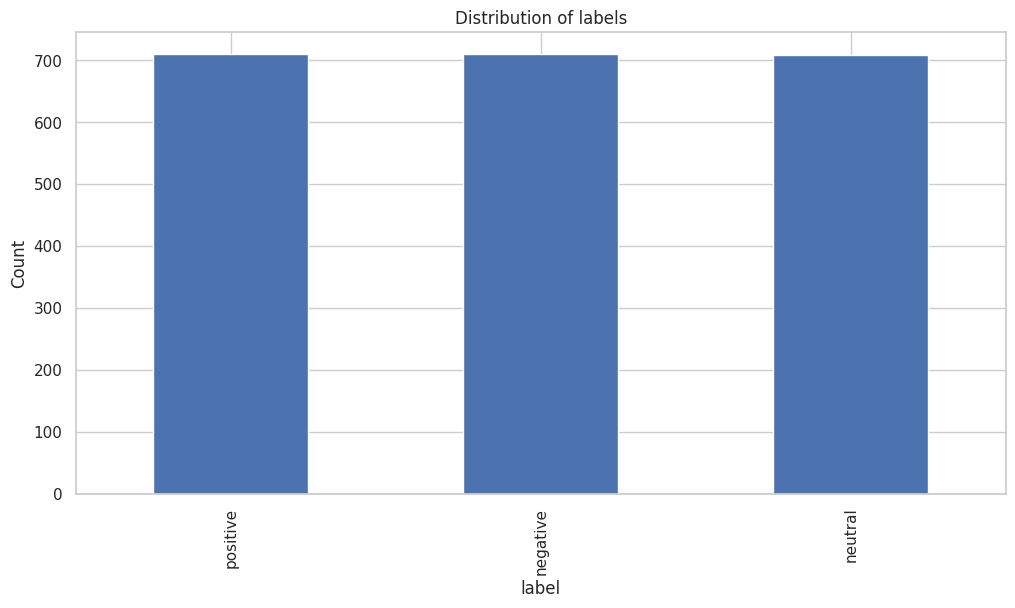

In [11]:
# Plotting the distribution of labels

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
df['label'].value_counts().plot(kind = 'bar')
plt.title('Distribution of labels')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [12]:
df.shape

(2129, 2)

In [13]:
# Preprocessing for classic ML models

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_classic(text):
    """Preprocess the text by removing non-letters, converting to lowercase,
    expanding contractions, removing stop words, and lemmatizing."""

    # Lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)

    # Tokenize
    words = word_tokenize(text)

    # Lemmatize + remove stopwords
    cleaned_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

    return " ".join(cleaned_words)


In [14]:
df['reply_clean'] = df['reply'].apply(preprocess_classic)

In [15]:
df.head()

,reply,label,reply_clean
0,Can we discuss pricing??,neutral,discus pricing
1,"Im excited to explore this further, plz send c...",positive,excited explore plz send contract
2,We not looking for new solutions.,negative,looking new solution
3,Could u clarify features included?,neutral,could clarify feature included
4,"lets,, schedule a meeting to dive deeper",positive,let u schedule meeting dive deeper


In [16]:
# Initialize encoder
le = LabelEncoder()

# Fit on labels and transform
y = le.fit_transform(df['label'])

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Classes mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [17]:
# 3. Save encoder for later use
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [18]:
df['label_encoded'] = y

In [19]:
df.head()

,reply,label,reply_clean,label_encoded
0,Can we discuss pricing??,neutral,discus pricing,1
1,"Im excited to explore this further, plz send c...",positive,excited explore plz send contract,2
2,We not looking for new solutions.,negative,looking new solution,0
3,Could u clarify features included?,neutral,could clarify feature included,1
4,"lets,, schedule a meeting to dive deeper",positive,let u schedule meeting dive deeper,2


In [20]:
X = df['reply_clean']
y = df['label_encoded']

In [21]:
# 1. Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [22]:
def vectorize_train_test(X_train, X_test, method='tfidf'):
    if method == 'bow':
        vectorizer = CountVectorizer()
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Method must be either 'bow' or 'tfidf'")

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, vectorizer


In [23]:
# TF-IDF
X_train_vec, X_test_vec, vec = vectorize_train_test(X_train, X_test, method='tfidf')

In [24]:
## Initialize and train
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [25]:
## Predict on test set
y_pred = lr.predict(X_test_vec)

In [26]:
## Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-macro:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9812206572769953
F1-macro: 0.9812525048038241

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      0.98      0.98       142
     neutral       0.99      0.98      0.99       142
    positive       0.97      0.99      0.98       142

    accuracy                           0.98       426
   macro avg       0.98      0.98      0.98       426
weighted avg       0.98      0.98      0.98       426



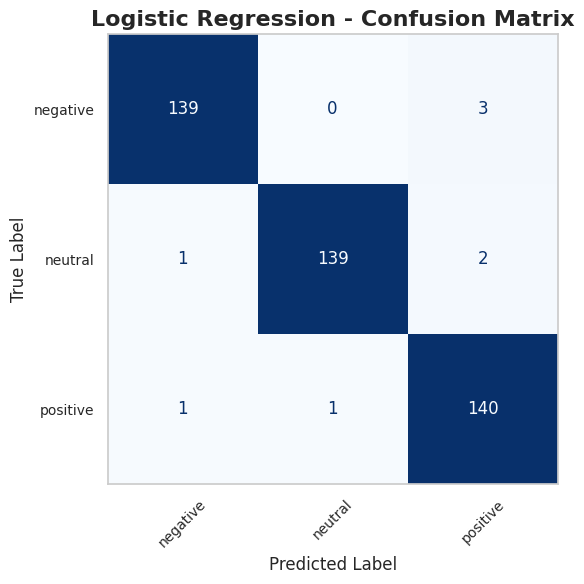

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create custom plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    ax=ax,
    colorbar=False  # Set to True if you want the color bar
)

# Custom styling
ax.set_title("Logistic Regression - Confusion Matrix", fontsize=16, fontweight='bold')
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

In [28]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(le.classes_),
    random_state=42
)

lgb_model.fit(X_train_vec, y_train)

# Predictions
y_pred_lgbm = lgb_model.predict(X_test_vec)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-macro:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 1703, number of used features: 75
[LightGBM] [Info] Start training from score -1.098025
[LightGBM] [Info] Start training from score -1.099787
[LightGBM] [Info] Start training from score -1.098025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


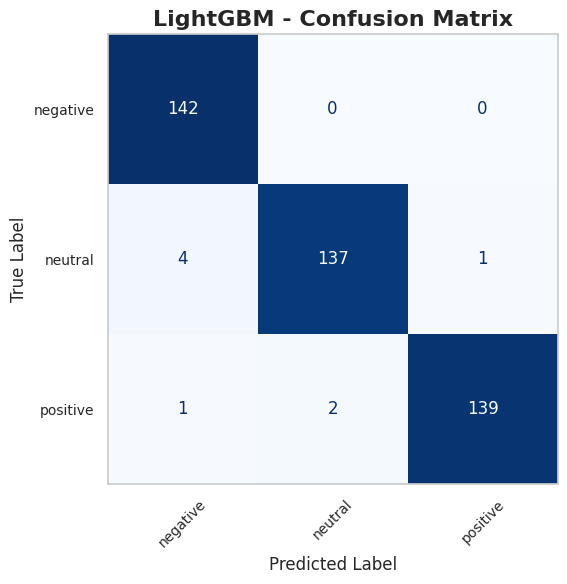

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create custom plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    ax=ax,
    colorbar=False  # Set to True if you want the color bar
)

# Custom styling
ax.set_title("LightGBM - Confusion Matrix", fontsize=16, fontweight='bold')
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

In [57]:
# Split train/validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

# Hugging Face dataset format
train_dataset = Dataset.from_pandas(train_df[['reply', 'label_encoded']].rename(columns={'reply': 'text', 'label_encoded': 'label'}))
val_dataset   = Dataset.from_pandas(val_df[['reply', 'label_encoded']].rename(columns={'reply': 'text', 'label_encoded': 'label'}))

In [58]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [59]:
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

In [60]:
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset   = val_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1703 [00:00<?, ? examples/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

In [61]:
# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [62]:
from transformers import AutoModelForSequenceClassification

In [63]:
num_labels = len(le.classes_)  # 3 classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

In [65]:
from transformers import TrainingArguments, Trainer

In [72]:
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none",
)

In [73]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

/tmp/ipython-input-234776172.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.068000,0.030766,0.995305,0.995305
2,0.014100,0.008782,0.997653,0.997653
3,0.005800,0.004188,1.000000,1.000000


TrainOutput(global_step=321, training_loss=0.11333410198164877, metrics={'train_runtime': 177.7958, 'train_samples_per_second': 28.735, 'train_steps_per_second': 1.805, 'total_flos': 169197002267904.0, 'train_loss': 0.11333410198164877, 'epoch': 3.0})

In [82]:
model.save_pretrained("distilbert_email_classifier")
tokenizer.save_pretrained("distilbert_email_classifier")

('distilbert_email_classifier/tokenizer_config.json',
 'distilbert_email_classifier/special_tokens_map.json',
 'distilbert_email_classifier/vocab.txt',
 'distilbert_email_classifier/added_tokens.json',
 'distilbert_email_classifier/tokenizer.json')

In [77]:
preds_output = trainer.predict(val_dataset)
y_pred_bert = preds_output.predictions.argmax(axis=1)   # predicted class indices
y_true = preds_output.label_ids                    # true labels

In [78]:
print("Accuracy:", accuracy_score(y_true, y_pred_bert))
print("F1-macro:", f1_score(y_true, y_pred_bert, average="macro"))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_bert, target_names=le.classes_))

Accuracy: 1.0
F1-macro: 1.0

Classification Report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       142
     neutral       1.00      1.00      1.00       142
    positive       1.00      1.00      1.00       142

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



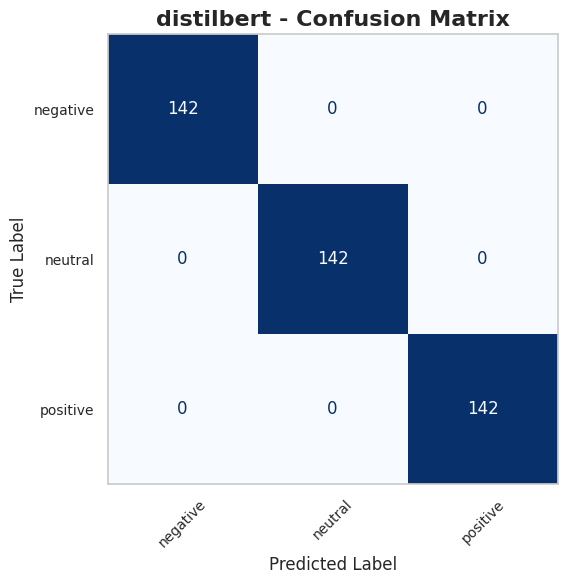

In [83]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_bert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create custom plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    ax=ax,
    colorbar=False  # Set to True if you want the color bar
)

# Custom styling
ax.set_title("distilbert - Confusion Matrix", fontsize=16, fontweight='bold')
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

In [84]:
results = {
    "Logistic Regression": {"Accuracy": 0.981, "Macro F1": 0.981},
    "LightGBM": {"Accuracy": 0.980, "Macro F1": 0.980},
    "distilbert (Transformer)": {"Accuracy": 0.995, "Macro F1": 0.995},
}

df_results = pd.DataFrame(results).T
df_results

,Accuracy,Macro F1
Logistic Regression,0.981,0.981
LightGBM,0.980,0.980
distilbert (Transformer),0.995,0.995


**Comparison**:

a.)***Logistic Regression (TF-IDF)***: Achieved ~98% accuracy and macro F1. It is extremely lightweight, fast to train, and easy to deploy.

b.) ***LightGBM (TF-IDF)***: Performed almost identically to Logistic Regression (~98%). While powerful for tabular data, it didn’t provide a meaningful gain here because email replies are short and mostly linearly separable in TF-IDF space.

c.) ***distilbert(Transformer)***: Achieved ~99.5% accuracy and macro F1. It captures deeper semantic context and generalizes better, especially for nuanced email replies. However, it is computationally heavier to train and deploy compared to Logistic Regression.

**Production Choice**:

For real-world deployment, I would choose ***Logistic Regression*** with TF-IDF because:

Performance is already very high (~98%).

It is lightweight, fast, and cheap to run in production.

Easier to retrain when new labeled data arrives.

If the dataset grows larger and contains more nuanced/ambiguous replies, I would then consider moving to a Transformer model like *distilbert* for better generalization.